# Foody - Food classifier
version 0.5 by BennyFace

model: foody_v05_convnext_large_in22k.pkl

dataset: food101 https://huggingface.co/datasets/food101

In [1]:
from fastai.vision.all import *
import gradio as gr
import os
import timm

In [2]:
home_path = os.getcwd()
home_path

'/home/bennyface'

In [3]:
home = Path(home_path)

In [4]:
#using the full food-101 dataset this time
trn_path = '/mnt/d/datasets/food-101'
trn_path

'/mnt/d/datasets/food-101'

In [ ]:
# files = get_image_files(trn_path)

In [ ]:
# files

In [ ]:
# check for corrupt images.
# corrupt = verify_images(files)
# corrupt

In [ ]:
# img = PILImage.create(files[0])
# print(img.size)
# img.to_thumb(512)

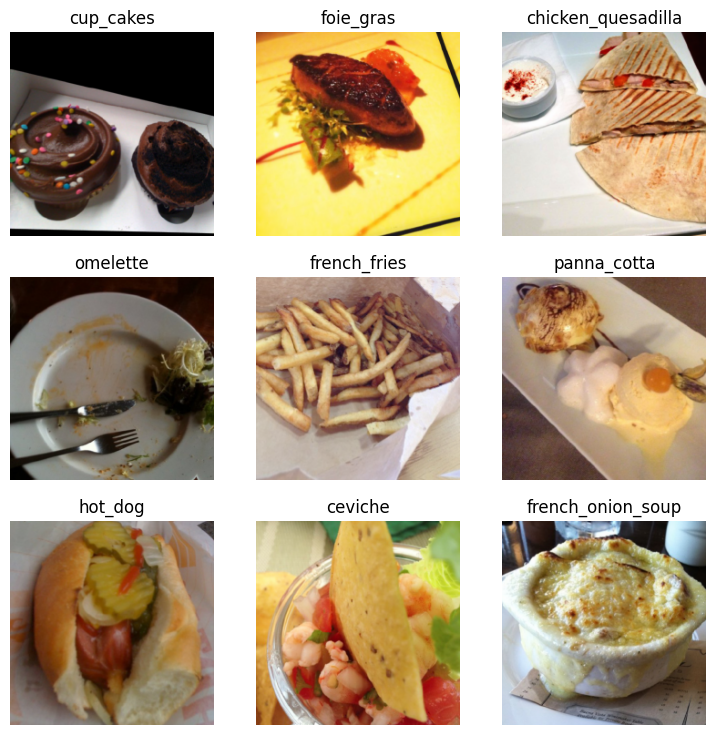

In [5]:
accum = 2 #reduce video ram - 2 works for my rtx 3060 12GB

dls = ImageDataLoaders.from_folder(
    trn_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),  # method='squish', method='randomresizecrop'  #, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=64//accum
)

dls.show_batch(max_n=9)


In [6]:
cbs = GradientAccumulation(64) if accum else []
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate, cbs=cbs).to_fp16()

SuggestedLRs(valley=0.0020892962347716093, slide=0.004365158267319202)

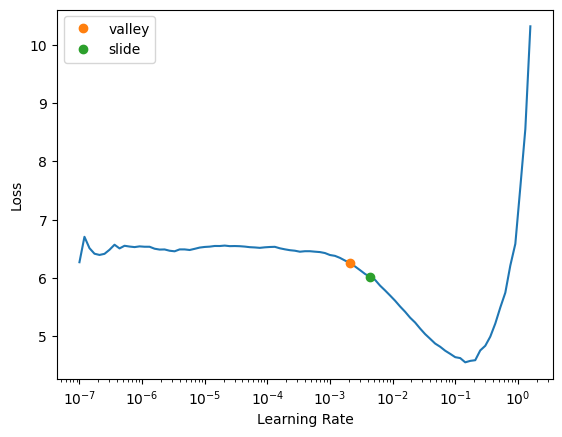

In [7]:
learn.lr_find(suggest_funcs=(valley, slide))

In [8]:
#train the model
learn.fine_tune(12, 0.002)

epoch,train_loss,valid_loss,error_rate,time
0,0.793311,0.579585,0.157590,19:09


epoch,train_loss,valid_loss,error_rate,time
0,0.504095,0.452881,0.122636,26:10
1,0.439878,0.432248,0.117338,26:10
2,0.448851,0.428812,0.115556,26:14
3,0.386828,0.419181,0.112981,26:20
4,0.371228,0.415280,0.106991,26:14
5,0.271316,0.418507,0.105704,26:13
6,0.219765,0.429458,0.104614,26:27
7,0.177213,0.438336,0.103575,26:40
8,0.126697,0.441823,0.101347,26:15
9,0.107432,0.443795,0.099366,26:07


In [9]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0992)

In [10]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0919)

In [11]:
# get the index with the greater probability
preds = probs.argmax(dim=1)

In [12]:
dls.vocab[preds]

(#20198) ['beet_salad','shrimp_and_grits','prime_rib','ceviche','paella','hamburger','miso_soup','tiramisu','gyoza','lobster_bisque'...]

In [13]:
learn.export('/home/bennyface/foody_v5_convnext_large_in22k.pkl')

In [14]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

In [15]:
# too many categories
# learning_interpreter.plot_confusion_matrix()

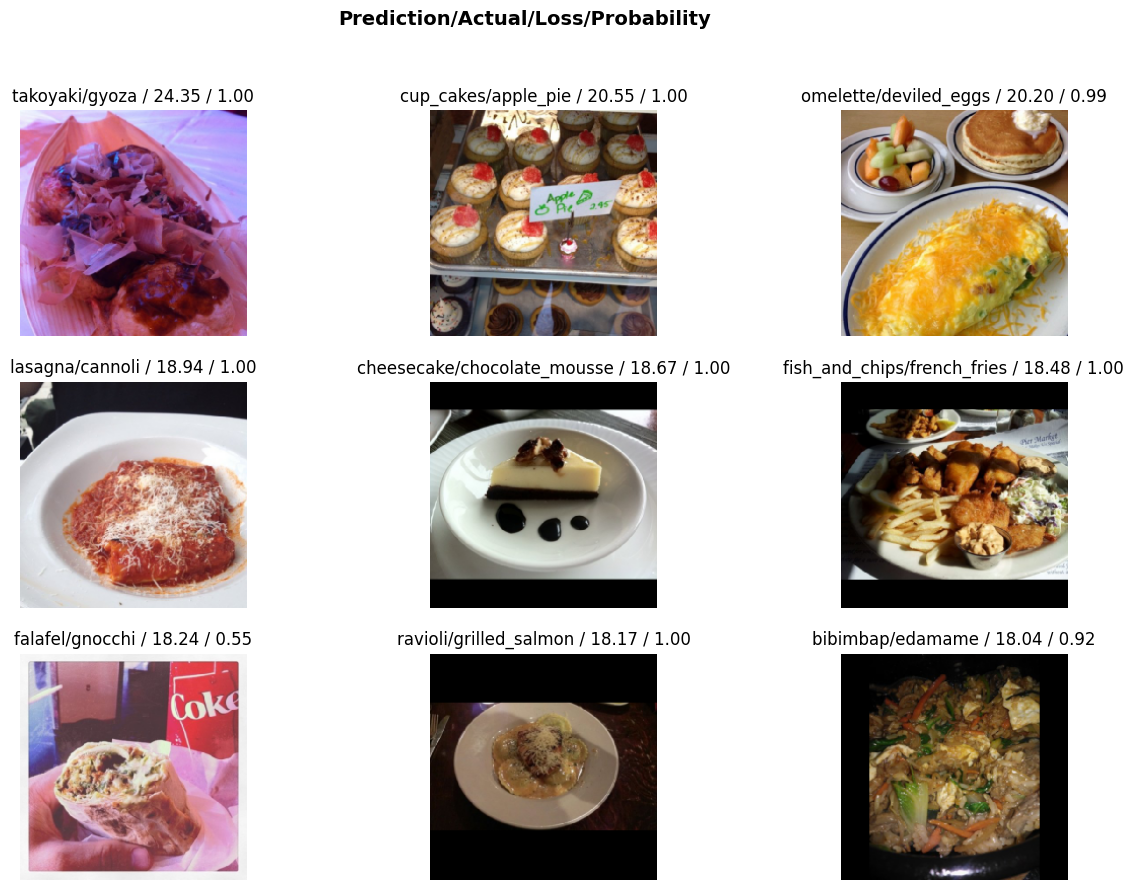

In [16]:
learning_interpreter.plot_top_losses(9, figsize=(15,10))

## Gradio App

In [17]:
learn = load_learner('/home/bennyface/foody_v5_convnext_large_in22k.pkl')

In [18]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [19]:
gr.Interface(fn=predict, inputs=gr.Image(shape=(512, 512)), outputs=gr.Label(num_top_classes=3)).launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://ae534bfa-cbc1-49d6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
